In [47]:
# MO444 2s/2017 - First assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Functions
def load_data(filename):
    raw_data = open(filename, 'rt')
    data = np.loadtxt(raw_data, delimiter=",")
    return data

def split_Y_X(dataset):
    Y = dataset[:,0]
    X = dataset[:,1:]
    return Y, X

def get_errors_by_year(model, data_Y, data_X):
    years = range(1922, 2011)
    errors = []
    for y in years:
        filt = data_Y == y
        if not sum(filt):
            errors.append(0)
            continue
        errors.append(mean_squared_error(data_Y[filt], lr_normalized_model.predict(data_X[filt])))
    return errors

In [3]:
# load training data
data = load_data('year-prediction-msd-train.txt')

print('Training data size: {}'.format(len(data)))

Training data size: 463715


In [4]:
# Take a look at the data (5 first instances):
# - first column (index 0) is the song release year
# - remaining columns are the the features (indexes 1 - 90)
data_frame = pd.DataFrame(data)
data_frame.head(5)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2004.0,46.50128,-18.37096,58.89824,27.28181,1.93097,-2.43167,18.64843,-5.62769,-1.47711,...,43.94716,-64.21148,13.04284,156.03785,-2.42670,51.71977,-43.56703,10.63735,24.08962,-21.41886
1,2005.0,41.46015,-52.30140,-4.59825,-19.28084,-11.85844,-19.54192,1.30306,-1.83185,5.98469,...,-13.48435,-154.65715,35.22429,89.53649,-3.13145,-128.28120,89.97277,-15.88139,-75.21074,-0.51139
2,2009.0,42.18667,-85.65863,-7.91506,-11.84193,-12.61959,-21.66749,4.97883,-11.86750,9.87342,...,42.08584,-181.77349,43.00181,87.94977,-13.70362,136.49979,140.32633,11.51422,382.79589,29.98269
3,1987.0,46.90244,19.86314,10.92119,4.87136,-41.17499,-19.84156,2.93308,-5.98711,3.05997,...,-2.76407,-20.31782,-75.24506,125.81801,-15.50828,-63.31002,-142.21937,-12.36699,32.45911,-17.14909
4,2009.0,46.64388,-81.99503,41.62851,3.65855,-9.38201,-13.51749,7.48781,-7.03302,7.06982,...,12.29244,-143.25348,91.15842,-227.85481,7.75916,-41.32376,-225.66526,-4.05081,455.39458,41.65310


In [5]:
# split train data into training/validation (80/20)
train_data, validation_data = train_test_split(data, test_size=0.2)

print('Train data size: {}'.format(len(train_data)))
print('Validation data size: {}'.format(len(validation_data)))

Train data size: 370972
Validation data size: 92743


In [6]:
# load test data
test_data = load_data('year-prediction-msd-test.txt')

print('Test data size: {}'.format(len(test_data)))

Test data size: 36285


In [7]:
# Split label (years) and features
train_data_Y, train_data_X = split_Y_X(train_data)
validation_data_Y, validation_data_X = split_Y_X(validation_data)
test_data_Y, test_data_X = split_Y_X(test_data)

In [8]:
# Create a baseline linear regression model and train it
lr_base_model = LinearRegression()
lr_base_model.fit(train_data_X, train_data_Y)

print('Number of coefficients: {}'.format(len(lr_base_model.coef_)))
print('Coefficients: {}'.format(lr_base_model.coef_))

Number of coefficients: 90
Coefficients: [  8.73849171e-01  -5.56242158e-02  -4.23535981e-02  -3.23402509e-04
  -1.48222799e-02  -2.22093045e-01  -5.62937818e-03  -1.03531876e-01
  -6.87388187e-02   2.24519375e-02  -1.58968943e-01  -2.34776907e-03
   4.65783003e-02   3.55893388e-04  -4.47697484e-04   5.99696003e-04
   4.32036313e-04   1.52889134e-03   2.06251871e-03   2.17814990e-03
   7.68735519e-04  -4.80073040e-04   7.82299232e-03   2.59172501e-03
  -3.53844403e-03   4.54955062e-05   1.60100072e-03   4.77167096e-04
   9.81200861e-04  -2.23512492e-04  -1.35568305e-03  -1.38577202e-03
  -5.31483149e-03   2.35184151e-03   1.65830512e-03  -5.10311403e-03
  -2.23068013e-04   6.92445254e-04   1.45970877e-03  -1.61605753e-03
  -2.05167648e-03  -6.17267045e-04  -1.51270288e-03  -2.62501701e-03
  -3.61948015e-03   6.73672609e-03   4.79547523e-04  -2.02990357e-03
   1.98857465e-04   2.06453072e-03  -1.16070210e-04  -1.82805348e-03
   1.81221498e-03   3.15496684e-04  -3.91702054e-04   7.443330

In [9]:
# A quick comparison on some instances of the validation data with the predicted values...
print('Actual: {}'.format(validation_data_Y[0:5]))
print('Predicted: {}'.format(lr_base_model.predict(validation_data_X)[0:5]))

Actual: [ 1999.  1996.  1957.  1973.  2002.]
Predicted: [ 1999.52789911  2000.31353126  1992.03680659  1994.57448     1996.56325446]


In [10]:
# ... and the errors
mean_sq_error_training = mean_squared_error(train_data_Y, lr_base_model.predict(train_data_X))
print('Training mean squared error: {}'.format(mean_sq_error_training))
print('Training root mean squared error: {}'.format(sqrt(mean_sq_error_training)))

mean_sq_error_validation = mean_squared_error(validation_data_Y, lr_base_model.predict(validation_data_X))
print('Validation mean squared error: {}'.format(mean_sq_error_validation))
print('Validation root mean squared error: {}'.format(sqrt(mean_sq_error_validation)))

Training mean squared error: 91.1484840088
Training root mean squared error: 9.54717151877
Validation mean squared error: 91.7156857191
Validation root mean squared error: 9.57683067195


In [11]:
# LR-based alternative #1: Data normalization
lr_normalized_model = LinearRegression(fit_intercept=True, normalize=True)

lr_normalized_model.fit(train_data_X, train_data_Y )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [12]:
# Check the model errors
mean_sq_error_training = mean_squared_error(train_data_Y, lr_normalized_model.predict(train_data_X))
print('Training mean squared error: {}'.format(mean_sq_error_training))
print('Training root mean squared error: {}'.format(sqrt(mean_sq_error_training)))

mean_sq_error_validation = mean_squared_error(validation_data_Y, lr_normalized_model.predict(validation_data_X))
print('Validation mean squared error: {}'.format(mean_sq_error_validation))
print('Validation root mean squared error: {}'.format(sqrt(mean_sq_error_validation)))

Training mean squared error: 91.1484840088
Training root mean squared error: 9.54717151877
Validation mean squared error: 91.7156857191
Validation root mean squared error: 9.57683067195


In [48]:
errors = get_errors_by_year(lr_normalized_model, validation_data_Y, validation_data_X)

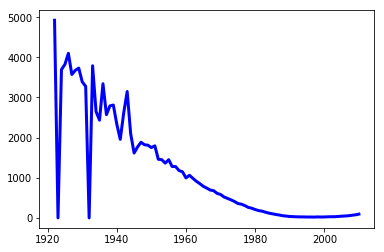

In [49]:
plt.plot(years, errors, color='blue', linewidth=3)
plt.show()